# Hybrid Models for Hyperspectral Image Classification

**Author**: Samuele Tomassacci 

**Student ID**: 2216267

# Introduction

The paper selected as reference for my project is ***C. Fu, T. Zhou, T. Guo, Q. Zhu, F. Luo, and B. Du,
"CNN-Transformer and Channel-Spatial Attention based network for hyperspectral image classification with few samples,"
Neural Networks, vol. 186, art. no. 107283, 2025, doi: 10.1016/j.neunet.2025.107283.***

In this paper, the authors tackle the problem of ***hyperspectral image classification*** in the scenario of limited training samples.  
Hyperspectral images cover a much broader spectral range, including bands for example in the near and mid-infrared regions compared to traditional RGB images.  
The abundance and redundancy of spectral information lead to the so-called ***"Curse of Dimensionality"***, therefore, the traditional algorithms for image classification are not able to capture the subtle dependencies between different bands, causing poor performance if applied to hyperspectral images.

Although the availability of hyperspectral data has increased in recent years, it is very rare that they are accompanied by labels. This scarcity represents a major challenge when training deep learning models for classification. In this project this problem will be faced, proposing a model whose training will be performed using a very limited number of samples (e.g. only 10 samples for each class).

In this work, these challenges are addressed through the following three key innovations:

1. ***Sample amplification algorithm***, which will try to generate new samples from the existing ones, mitigating the lack of labels problem.
2.  A ***hybrid module*** based on CNNs, that will capture the local properties of the data and Transformers to capture the non-local ones.
3.  A ***spatial-channel attention*** to overcome the curse of dimensionality in combination with the hybrid CNN-Transformer module.

The complete model that will be implemented is called ***CTA-Net***.
The model will be evaluated on the ***Pavia University dataset***.




# Theoretical background

Before entering the details of the proposed model, I would like to provide a brief summary of the two key concepts used in this paper: CNN and Transformer modules .

**Convolutional Neural Networks**  

Convolutional Neural Networks were developed to operate with data with a high spatial structure, such as images and they have become one of the most powerful tool to work with them. They are based on the principle that in an image nearby pixels are strongly correlated with each other, with respect to pixels that are further away. This property is exploited through 2D convolution. 
Given an input image with $C_{\text{in}}$ channels and an output feature map with $C_{\text{out}}$ channels, 
the input tensor is formally defined as 
$X \in \mathbb{R}^{H \times W \times C_{\text{in}}}$, 
while the convolutional kernel is 
$K \in \mathbb{R}^{k \times k \times C_{\text{in}} \times C_{\text{out}}}$. 
The resulting convolution operation is given by:

$$
Y(i,j,m) =
\sum_{c=0}^{C_{\text{in}}-1}
\sum_{u=0}^{k-1}
\sum_{v=0}^{k-1}
X(i+u, j+v, c)\, K(u, v, c, m)
$$

In addition to the kernel, there are other parameters that must be chosen when a convolution operation is defined:
* ***Stride***: it is the step size taken by the kernel during the convolution operation.
* ***Padding***: if the padding is not used, the dimensions of the output image will decrease, if we want to keep the same dimensions we must add padding pixels at the border of the image


**Transformers**

In Transformers the assumption of locality is overcome, allowing the model to capture also non-local features of the data. For this reason, Transformers have become the main architecture for working with text, where the meaning of the words does not depend only on the nearby ones but on the entire context.
Transformers work with sequences of tokens, therefore the data need to be pre-processed before being given as input, with the following two steps:
* ***Tokenization***: data must be divided into basic units called tokens
* ***Embedding***: each token must be converted into numerical features.

The figure below describes the architecture of a transformer block:
<p align="center">
  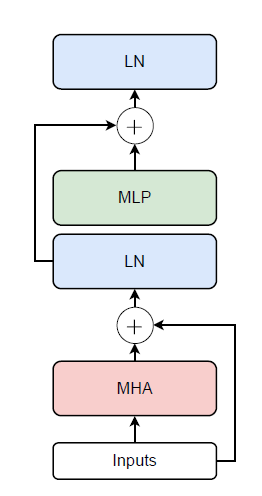
</p>

In particular there are layer normalization operations, MLP layers and residual connections, however the key component is the ***MHA*** (multi-head-self-attention). The aforementioned works in the following way:
Given the input $X \in R^{n \times d}$, it computes the Keys, Queries and Values matrices:
$$
Q_t = XW_{q,t}  \:\:\:\: K_t = XW_{k,t} \:\:\:\: V_t= XW_{v,t}
$$
And then the output of the generic $t$ head:
$$ 
H_t = softmax(\frac{Q_tK_t^T}{\sqrt{q}})V_t
$$
Considering a total of $h$ heads, the final output can be computed as follows:
$$
H = [ H_1 ... H_h ] W_0
$$


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import scipy.ndimage as ndi
from scipy.io import loadmat

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
patch_size = 15

Device: cuda


# The dataset

The dataset used is the ***Pavia University*** dataset. It was acquired during a flight campaign over the Pavia University in Northern Italy in 2001 using the ROSIS sensor. The image size is 610x340, with 103 spectral bands. 
In the hyperspectral image, 42,776 pixels are labelled into 9 different categories. 

In the following image, more detailed information can be observed:
<p align="center">
  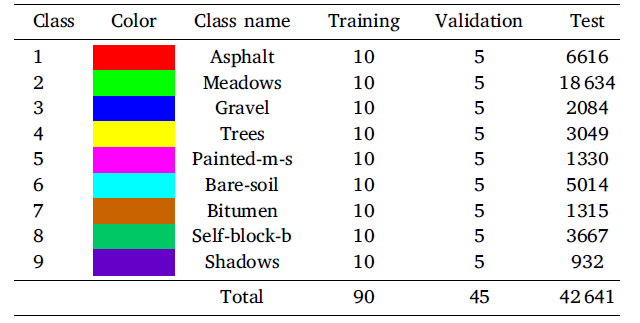
</p>

The input to model is a patch 15x15, centred on the pixel that has to be classified. As shown in the figure, this is a scenario with few training samples, specifically only 10 patches per class are extracted, leading to a total number of 90 training samples. For validation, only 5 samples per class are used, for a total of 45 samples. All remaining pixels are used for testing. 

In [3]:
#Extracting data from the dataset

data_path = "/kaggle/input/pavia-university-hsi/PaviaU.mat"
labels_path   = "/kaggle/input/pavia-university-hsi/PaviaU_gt.mat"


data = loadmat(data_path)["paviaU"]
labels = loadmat(labels_path)["paviaU_gt"]

print(f"Shape of the dataset: {data.shape}")
print(f"Shape of the labels: {labels.shape}")
print(f"Number of classes: {labels.max()}")

H,W,C = data.shape
num_classes = labels.max()

Shape of the dataset: (610, 340, 103)
Shape of the labels: (610, 340)
Number of classes: 9


In [4]:
#Data normalization, with mean and std per channel

data_flat = data.reshape(H*W,C)
mean = data_flat.mean(axis=0,keepdims=True)
std = data_flat.std(axis = 0,keepdims=True)
data_norm = ((data_flat-mean)/std).reshape(H,W,C)

#Padding to extract patches also at the borders of the image
pad = patch_size//2
data_pad = np.pad(data_norm,((pad,pad),(pad,pad),(0,0)), mode="reflect")

# Sample amplification module

Since training samples are extremely limited, data augmentation is necessary to achieve good results. For each training sample, three different transformations are applied, the transformed samples are added to the training dataset together with the original ones, allowing the dataset to be increased from 90 samples to 360 samples.
These are the transformations used:

* ***Addition of random gaussian noise***: since in a hyperspectral patch, the central pixel is much more important than the surrounding ones, the noise is added only to pixels outside of the central area of the patch, this area is a hyperparameter that can be freely chosen. The best results are achieved using a size of 1x1, thus, in practice, excluding only the central pixel.

* ***Random rotation***: each patch is rotated by a random angle, that can vary from -180° to +180°. In the case of rotations different from $\pm$ 90° and $\pm$180°, a cubic spline interpolation is used.

* ***Linear summation***: for each sample, another patch of the same class is randomly extracted and a linear combination of the two is performed. Given the two samples: $s_1$,$s_2$, and a parameter $\lambda$, which can be freely chosen, the following formula is used:
$
\frac{s_1+\lambda s_2}{1+\lambda}
$

In [5]:
# Data Augmentation

config_augmentation = {
    "central_region" : 1,
    "noise_sigma" : 0.03,
    "linear_lam_min" : 0.0,
    "linear_lam_max" : 0.25
}


def add_noise(patch,config): 
    
    C, P, _ = patch.shape
    out = patch.copy()
    c = P // 2
    r = config["central_region"] // 2
    mask = np.ones((P, P), dtype=np.float32)
    mask[c-r:c+r+1, c-r:c+r+1] = 0.0  #To exclude the central region
    noise = np.random.normal(0.0, config["noise_sigma"], size=out.shape).astype(np.float32)
    out += noise * mask[None, :, :]
    return out


def rotate(patch):
    angle = np.random.uniform(-180, 180)
    return ndi.rotate(
        patch,
        angle,          
        axes=(1, 2),
        reshape=False,
        order=3,
        mode="reflect"
    )


def linear_sum(patch_1, patch_2, lam):
    return (patch_1 + lam * patch_2) / (1.0 + lam)
    

def apply_augmentation(patch, c, augmentation_type, config, train_patches_extracted):
    
    if augmentation_type==1:
        patch = add_noise(patch,config)
    elif augmentation_type ==2:
        patch = rotate(patch)
    elif augmentation_type ==3:
         possible_patches = train_patches_extracted.get(c, [])
         if len(possible_patches) > 0:
            other = possible_patches[np.random.randint(0, len(possible_patches))]
            lam = np.random.uniform(config["linear_lam_min"], config["linear_lam_max"])
            patch = linear_sum(patch, other, lam=lam)
    return patch
   

        
        

In [6]:
def extract_patch(data,y,x):
    
    y0, x0 = y + pad, x + pad
    p = data[y0-pad:y0+pad+1, x0-pad:x0+pad+1, :] 
    
    return np.transpose(p, (2,0,1)).copy()




def build_datasets(labels,seed,train_per_class,val_per_class):
    
    coords_by_class = {}
    for c in range(1,num_classes+1):   #Extract all the valid coordinates for central pixel with a class associated
        y,x = np.where(labels==c)
        coords = list(zip(y.tolist(),x.tolist()))
        coords_by_class[c]=coords

    random_generator = np.random.RandomState(seed)
    train_coords,val_coords,test_coords = [],[],[]
    for c in range(1,num_classes+1):   
        coords = coords_by_class[c]
        random_generator.shuffle(coords)    #Shuffle to make the division in train, val and test random
        train = coords[:train_per_class]   
        val = coords[train_per_class:train_per_class+val_per_class]
        test = coords[train_per_class+val_per_class:]
        for (y,x) in train:
            train_coords.append((y,x,c))
        for (y,x) in val:
            val_coords.append((y,x,c))
        for (y,x) in test:
            test_coords.append((y,x,c))
    return train_coords, val_coords, test_coords
    
   

    

class dataset(Dataset):
    
    def __init__(self, data, samples, patch, train_dataset_flag, config, train_patches_extracted,use_augmentation):
      self.data = data
      self.samples_coords = samples
      self.patch_size = patch
      self.train_dataset_flag = train_dataset_flag
      self.train_patches_extracted = train_patches_extracted
      self.config =config
      self.use_augmentation = use_augmentation
      
      if (self.train_dataset_flag==True and self.use_augmentation==True):
          
          train_expanded = []
          for (y,x,c) in self.samples_coords:
              for augmentation_modality in [0,1,2,3]:
                  train_expanded.append((y,x,c,augmentation_modality))  #Apply all the tranformations to a training sample and add it to the dataset
          self.expanded = train_expanded
      else:
          expanded = []
          for (y,x,c) in self.samples_coords:
                  expanded.append((y,x,c,0))
          self.expanded = expanded
    
    def __len__(self):
        
        return len(self.expanded)
    
    def __getitem__(self, idx):
        
        y,x,c,aug = self.expanded[idx]
        
        patch = extract_patch(self.data,y,x)

        if (self.train_dataset_flag == True):

            patch = apply_augmentation(patch,c, aug,self.config,self.train_patches_extracted)
        
        label = c-1
        return torch.from_numpy(patch).float(), torch.tensor(label, dtype=torch.long)      

# Proposed method

The model used is called ***CTA-Net***. It is mainly composed of three components:
* ***CNN block***: it is used to extract and capture the local features of the hyperspectral patches.
* ***Transformer block***, while the CNN block is focused on the local features, the transformer block allows to capture the non-local ones, obtaining a better understanding of the entire patch.
* ***Channel-spatial attention***, the CNN and Transformer block are executed in a parallel  taking the same input tensor, the two outputs are concatenated along the band axis followed by a convolution operation to restore the original number of channels, the data are passed to this last layer called channel-spatial attention. It is used to fully exploit the channel-spatial features present in the hyperspectral patch, as both are extremely important for classification task.

<p align="center">
  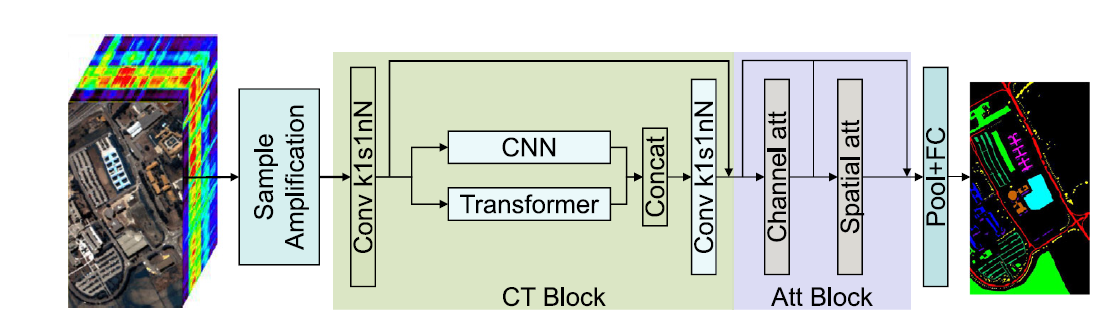
</p>



The following sections describe the three modules individually.

**CNN block**

In the CNN block, four different branches are used in parallel, the outputs are then taken and concatenated along the band axis, followed by  convolution operation to restore the initial number of channels.
In all four branches the number of channels isn't modified, therefore if the input has $N$ channels, during the 2D convolution $N$ kernels are used to keep the same dimensions. Furthermore, each convolution operation is followed by a ***batch normalization*** and a ***GELU activation function***.
The first branch performs a 2D convolution with a kernel of size 1x1, using stride 1. The second one uses a kernel of size 3x3. The third branch performs two consecutive convolutions, both with a kernel size 3x3 and finally the last one stacks three consecutive convolutions again with a kernel size 3x3.
The use of different kernel size allows to capture local information at different scales, improving the non linear representation ability of the CNN module.

<p align="center">
  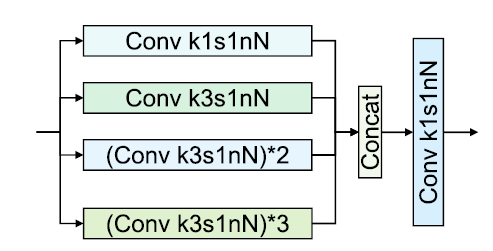
</p>


In the image ConvkKsSnN indicates a 2D convolution with a convolution kernel of size K, a stride S and an output channel number of N

**Transformer Block**

The transformer block works with sequences of tokens, in this case each token is a pixel and the sequence is represented by all the pixels inside the 15x15 patch. Before entering the transformer block, the patch is passed through a convolution layer, in which the number of channels is augmented from 103 (original number of bands of the hyperspectral image) to 128 channels. This corresponds to the embedding process, necessary for the transformer block.
As we can see from the figure the transformer block is composed of the following sequence:
* Feed-Forward module
* MHSA block
* Convolution operation
* Feed-Forward module
* Layer Normalization

***Residual connections*** are applied between modules to avoid gradient computation issues.
The number of heads used in the MHSA layer is set to 8. 

Furthermore, a relative positional encoding is used to provide the block with information about the position of each pixel inside the patch. 
Instead of using absolute positional encoding, this approach models the relative spatial relationships between tokens. All possible relative offsets $(\Delta h, \Delta w)$ within the window are enumerated, resulting in $(2H-1)(2W-1)$ unique relative positions. Each relative position is associated with a learnable bias for each attention head. 
A lookup table stores these biases, while a precomputed index maps every token pair to its corresponding relative offset. During the forward pass, this index is used to efficiently gather the bias values. The resulting bias is added to the attention logits, enabling the model to better capture spatial structure and translation-aware inductive bias.

<p align="center">
  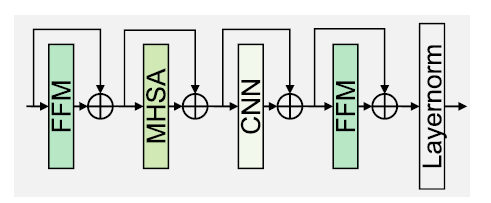
</p>


**Channel-spatial attention**

In channel attention, for each channel we learn a weight to apply to it, in this way we can give more importance to some channels compared to others. The patch is taken as input and global pooling across the spatial dimensions $H,W$ is made. The result is a vector with a number of components equal to the number of channels. A 1D convolution is then applied on this vector, producing the weights as output that will be multiplied to the original patch.

In spatial attention, the weights learned are for spatial positions within the patch, finding which pixels $(i,j)$ are more relevant. First, some statistics are extracted, such as max, min, mean and std across the channel axis. These four maps are concatenated to form a tensor of dimensions $(4,P,P)$ where $P=15$ in our case. The tensor passes through two parallel convolutional layers, after these operations, the final weights are extracted and multiplied with the original patch.

<p align="center">
  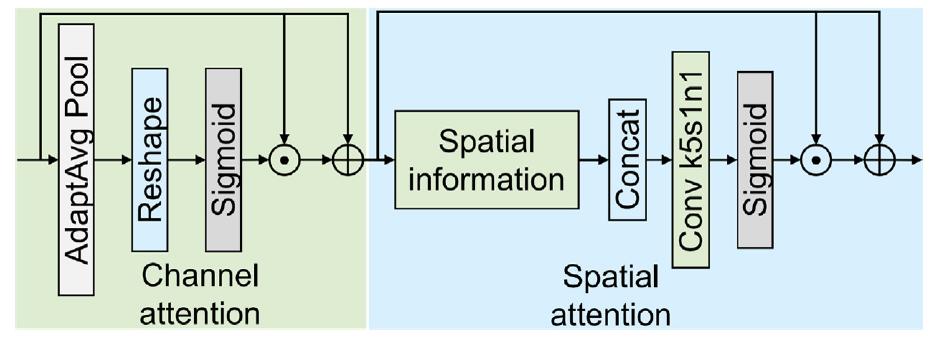
</p>


In [7]:
config_training = {
    "num_heads":8,
    "attn_dropout":0.1,
    "ff_dropout":0.1,
    "ff_factor":4,
    "patch_size":15,
    "cnn_dropout":0.1
    
}

# As described in the paper conv is followed by batch normalization and GELU
def conv_layers(in_channels, out_channels, kernel_size, stride=1,padding=None):
    if padding is None:
      padding = kernel_size//2
    layers = nn.Sequential(
        nn.Conv2d(in_channels,out_channels, kernel_size = kernel_size,stride = stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.GELU())
    return layers
      


class CNN_block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        #Definition of the four parallel blocks
        self.block1 = conv_layers(channels,channels,1)
        self.block2 = conv_layers(channels,channels,3)
        self.block3 = nn.Sequential(
            conv_layers(channels,channels,3),
            conv_layers(channels,channels,3))
        self.block4 = nn.Sequential(
            conv_layers(channels,channels,3),
            conv_layers(channels,channels,3),
            conv_layers(channels,channels,3))
        
        self.reduce_channels = conv_layers(4*channels,channels,1)
        
    def forward(self,x):
        residual = x
        out = torch.cat([self.block1(x),self.block2(x),self.block3(x),self.block4(x)],dim=1)
        return self.reduce_channels(out)+residual
        
class FFM(nn.Module):
    def __init__(self, dim, mult, dropout):
        super().__init__()
        inner = dim*mult
        self.block = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim,inner),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(inner,dim),
            nn.Dropout(dropout))
    def forward(self,x):
         return self.block(x)

class RelativePositionBias2D(nn.Module):
    
    def __init__(self, num_heads: int, H: int, W: int):
        super().__init__()
        self.num_heads = num_heads
        self.H, self.W = H, W
        
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * H - 1) * (2 * W - 1), num_heads)
        )
        nn.init.trunc_normal_(self.relative_bias_table, std=0.02)

    
        coords_h = torch.arange(H)
        coords_w = torch.arange(W)
        coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))  
        coords_flatten = torch.flatten(coords, 1)  

        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += H - 1
        relative_coords[:, :, 1] += W - 1
        relative_coords[:, :, 0] *= 2 * W - 1
        relative_position_index = relative_coords.sum(-1)  

        self.register_buffer("relative_position_index", relative_position_index, persistent=False)

    def forward(self):
        N = self.H * self.W
        bias = self.relative_bias_table[self.relative_position_index.view(-1)]  
        bias = bias.view(N, N, self.num_heads).permute(2, 0, 1).contiguous()   
        return bias


class MHSA(nn.Module):
    
    
    def __init__(self, dim, nheads, dropout, H, W):
        super().__init__()
    
        self.dim = dim
        self.nheads = nheads
        self.head_dim = dim // nheads
        self.scale = self.head_dim ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

        self.rpb = RelativePositionBias2D(nheads, H, W)

    def forward(self, x):
        B, N, D = x.shape
        residual = x
        x = self.norm(x)

        qkv = self.qkv(x).reshape(B, N, 3, self.nheads, self.head_dim)
        q, k, v = qkv.unbind(dim=2)  
        q = q.permute(0, 2, 1, 3)    
        k = k.permute(0, 2, 1, 3)   
        v = v.permute(0, 2, 1, 3)    
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, heads, N, N)
        attn = attn + self.rpb().unsqueeze(0)          

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v                                  # (B, heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, D)       # (B, N, D)
        out = self.proj(out)
        out = self.proj_drop(out)

        return out + residual


class CNN_block_transformer(nn.Module):
    def __init__(self, dim, dropout):
      super().__init__()
      self.layerNormalization = nn.LayerNorm(dim)
      self.conv1_1 = nn.Linear(dim,2*dim, bias=True) 
      self.conv2 = nn.Conv2d(dim,dim,kernel_size=3,padding=1,groups=dim,bias=False)
      self.batchNormalization = nn.BatchNorm2d(dim)
      self.conv1_2 = nn.Linear(dim,dim,bias=True)
      self.act = nn.SiLU()
      self.dropout = nn.Dropout(dropout)
    
    def forward(self,x, H, W):
        residual = x
        B, N, D = x.shape 
        x = self.layerNormalization(x)
        x =  self.conv1_1(x)   
        a,b = x.chunk(2,dim=-1)
        x=a*torch.sigmoid(b)
        
        feat = x.reshape(B, H, W, D).permute(0, 3, 1, 2)
        feat = self.conv2(feat)
        feat = self.batchNormalization(feat)
        feat = self.act(feat)
        x = feat.permute(0, 2, 3, 1).reshape(B, H*W, D)
        x = self.conv1_2(x)   
        x = self.dropout(x)
        return x+residual

class Transformer_block(nn.Module):
    
    def __init__(self, n_channels, heads, ff_factor, ff_dropout, attn_dropout,cnn_dropout, patch_size):
      super().__init__()
      
      self.ff1= FFM(n_channels, ff_factor, ff_dropout)
      
      self.mhsa = MHSA(n_channels, heads, attn_dropout, H=patch_size, W=patch_size)
      self.conv = CNN_block_transformer(n_channels,cnn_dropout)
      self.ff2= FFM(n_channels, ff_factor, ff_dropout)
      self.final_norm = nn.LayerNorm(n_channels)
    
    def forward(self,x):   
        
        B,C,P,P = x.shape
        tokens = x.reshape(B,C,P*P).permute(0,2,1)   #(B,P*P,C)
        

        tokens = tokens+self.ff1(tokens)     #Data automatically reshaped to (B*P*P,C)
                                             
        tokens = self.mhsa(tokens)
        tokens = self.conv(tokens,H=P,W=P)
        tokens= tokens +self.ff2(tokens)
        tokens = self.final_norm(tokens)
        output = tokens.permute(0,2,1).reshape(B,C,P,P)
        return output

#Put together the Convolution and Transformer block to create the CT block
class CT_block(nn.Module):
    def __init__(self,n_channels,patch_size, config):
        super().__init__()
        self.cnn_block = CNN_block(n_channels)
        self.transformer_block = Transformer_block(n_channels, config["num_heads"], config["ff_factor"], config["ff_dropout"], config["attn_dropout"],config["cnn_dropout"], patch_size)

        self.reduce_channels = conv_layers(2*n_channels,n_channels,1)

    def forward(self,x):
        residual = x
        output = torch.cat([self.cnn_block(x),self.transformer_block(x)],dim=1)
        output = self.reduce_channels(output)
        return output+residual
        
        

class ChannelAttention(nn.Module):
    def __init__(self,n_channels):
        super().__init__()
        self.conv = nn.Conv1d(n_channels, n_channels, kernel_size=3, padding=1, groups=1, bias=True)

    def forward(self,x):
        residual = x
        weight = x.mean(dim=(2,3), keepdim=False)
        weight = weight.unsqueeze(-1)
        weight = self.conv(weight)
        weight = torch.sigmoid(weight).unsqueeze(-1)
        y = x*weight
        return y+residual

class SpatialAttention(nn.Module):
   
    def __init__(self, ch):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(4, ch, kernel_size=5, padding=2, bias=False),
            nn.PReLU()
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(4, ch, kernel_size=5, padding=2, bias=False),
            nn.PReLU()
        )
        self.fuse = nn.Conv2d(2*ch, ch, kernel_size=1, bias=True)

    def forward(self, x):
        r = x
       
        mx, _ = x.max(dim=1, keepdim=True)
        mn, _ = x.min(dim=1, keepdim=True)
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)
        s = torch.cat([mx, mn, mean, std], dim=1)  # (B,4,H,W)

        b1 = self.branch1(s)
        b2 = self.branch2(s)
        f = torch.cat([b1, b2], dim=1)
        w = torch.sigmoid(self.fuse(f))         # (B,C,H,W)
        y = x * w
        return y + r

class ChannelSpatialAttention(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.channel_attention = ChannelAttention(n_channels)
        self.spatial_attention = SpatialAttention(n_channels)

    def forward(self, x):
        x = self.channel_attention (x)
        x = self.spatial_attention(x)
        return x

# The original bands are 103, but thanks to a first convulution they are brought to 128 
#and then for all the model they are kept at 128, so difference between in_band and n_channels

class CTA_full_model(nn.Module):  
    
    def __init__(self, in_bands, num_classes, n_channels, patch_size, config, use_CT_block, use_channel_spatial_att):  
        super().__init__()
        self.increase_channels = conv_layers(in_bands, n_channels, 1)   #From 103 band to 128 channels
        self.CT_block = CT_block(n_channels, patch_size, config)
        self.spatial_attention_block = ChannelSpatialAttention(n_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_channels, num_classes)
        self.use_CT_block = use_CT_block
        self.use_channel_spatial_att = use_channel_spatial_att

# The shape of the input x is (B,C,P,P) with C=103 and P=15, so it is a patch 15x15 with every pixels inside with 103 channels
    def forward(self, x):
        x = self.increase_channels(x)
        if self.use_CT_block:
          x = self.CT_block(x)
        if self.use_channel_spatial_att:
          x = self.spatial_attention_block(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x
    

# The metrics

The metrics used for model evaluation are: 
* **Overall Accuracy**
* **Average Accuracy**
* **Kappa coefficient**
  
The ***Overall Accuracy*** is the ratio between the total number of correct predictions and the total number of samples. Formally, given $K$ number of classes, $N$ total samples and $n_{ij}$ denotes the number of samples of class $i$ predicted as class $j$, the formula is:

$$ 
OA = \frac{\sum_{i=1}^{K} n_{ii}}{N}
$$ 

The ***Average Accuracy*** is the mean of the accuracies computed individually for each class, using the same symbols defined above, the formula is:

$$
AA = \frac{1}{K}\sum_{i=1}^{K} \frac{n_{ii}}{\sum_{j=1}^{K}n_{ij}}
$$

Finally, the ***Kappa coefficient*** is defined using two quantities: $p_0$ which is the standard accuracy and $p_e$, which represents the accuracy if the labels are assigned in a random way. The formula is:

$$
K = \frac{p_0-p_e}{1-p_e}
$$

In [8]:
def confusion_matrix(predictions, labels, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for prediction, label in zip(predictions, labels):    
        cm[label, prediction] += 1
    return cm

def metrics_from_confusion_matrix(cm): 
    num_classes = cm.shape[0]
    total = cm.sum()
    correct = np.trace(cm)
    overall_accuracy = correct / (total + 1e-12)

    per_class = np.diag(cm) / (cm.sum(axis=1) + 1e-12)
    average_accuracy = per_class.mean()

    # Kappa
    row = cm.sum(axis=1)
    col = cm.sum(axis=0)
    pe = (row @ col) / ((total + 1e-12) ** 2)
    kappa = (overall_accuracy - pe) / (1 - pe + 1e-12)

    return {"OA": overall_accuracy, "AA": average_accuracy, "Kappa": kappa, "per_class": per_class}

In [9]:
@torch.no_grad()
def eval_model(model, loader, num_classes):
    model.eval()
    all_predictions, all_labels = [], []
    for patch, label in loader:
        patch = patch.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)
        logits = model(patch)
        pred = logits.argmax(dim=1)
        all_predictions.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())
    predictions = np.concatenate(all_predictions)
    labels = np.concatenate(all_labels)
    cm = confusion_matrix(predictions, labels, num_classes)
    return metrics_from_confusion_matrix(cm), cm

def train_one_run(run_seed, use_augmentation, ablation_study, use_CT_block, use_channel_spatial_att):
    
    best_path = f"/kaggle/working/best_model_run_{run_seed}.pth"


    set_seed(run_seed)

    train_samples,val_samples,test_samples = build_datasets(labels, seed=run_seed, train_per_class=10, val_per_class=5)  
        
    training_patches_extracted ={}
    for c in range(1,num_classes+1):
        training_patches_extracted[c]=[]
    
    for (y,x,c) in train_samples:
        training_patches_extracted[c].append(extract_patch(data_pad, y, x))
    
    #Building the datasets
    train_ds = dataset(data_pad, train_samples, patch_size, True, config_augmentation, training_patches_extracted,use_augmentation)
    val_ds = dataset(data_pad, val_samples, patch_size, False, config_augmentation, training_patches_extracted,use_augmentation)
    test_ds = dataset(data_pad, test_samples, patch_size, False, config_augmentation, training_patches_extracted,use_augmentation) 
    

    BATCH = 32  
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


    # in_bands=103 because the dataset contains images with a resolution of 103 bands
    # n_channels=128 because in the paper the best result are obtained with 128
    
    model = CTA_full_model(in_bands=103, num_classes=num_classes, n_channels=128, patch_size=config_training["patch_size"], config=config_training,use_CT_block=use_CT_block, use_channel_spatial_att= use_channel_spatial_att).to(device) 

    
    opt = torch.optim.Adam(model.parameters(), lr=8e-5)
    criterion = nn.CrossEntropyLoss()

    best_val_metric = -1.0
    best_state = None

    EPOCHS = 150  

    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0.0
        for patch, label in train_loader:
            patch = patch.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            logits = model(patch)
            loss = criterion(logits, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * patch.size(0)

       
        val_metrics, _ = eval_model(model, val_loader, num_classes)
        if val_metrics["OA"] >= best_val_metric:
            best_val_metric = val_metrics["OA"]
            torch.save(model.state_dict(), best_path)
           
        if ablation_study == False:
            if epoch % 25 == 0 or epoch == 1:
                print(f"Epoch {epoch:03d}/{EPOCHS} | "
                      f"TrainLoss={total_loss/len(train_ds):.4f} | ValOA={val_metrics['OA']*100:.2f}")
    
    
    state = torch.load(best_path, map_location=device)
    model.load_state_dict(state)
    

    test_metrics, cm = eval_model(model, test_loader, num_classes)
    return test_metrics, cm, model


# Experimental setting

The optimizer used is ***Adam*** and the loss function is ***Cross-Entropy***, since it is a classification task.
The number of training epochs is 150, the final model saved is the one that reaches the best performances in terms of Overall Accuracy on the validation dataset, whose metrics are computed at the end of each epoch.

After training, the best model is evaluated on the test dataset.
Given the limited number of training samples, running the previous pipeline only once, would lead to unstable results, mainly depending on the selected training samples. For this reason, 10 consecutive runs are executed, saving the metrics computed on the test dataset. The final metrics used for the evaluation of the overall model are the ***mean and standard deviation*** of the performance achieved across all the 10 runs.

In [10]:
BASE_SEED = 2040

all_OA, all_AA, all_K, all_PC = [], [], [], []
best_OA = -10

for i in range(10):
    seed = BASE_SEED + i
    test_metrics, _, model = train_one_run(seed,use_augmentation=True, ablation_study=False,use_CT_block=True, use_channel_spatial_att=True)
    all_OA.append(test_metrics["OA"])
    all_AA.append(test_metrics["AA"])
    all_K.append(test_metrics["Kappa"])
    all_PC.append(test_metrics["per_class"])
    print(f"Run {i+1}/10 | OA={test_metrics['OA']*100:.2f} AA={test_metrics['AA']*100:.2f} Kappa={test_metrics['Kappa']*100:.2f}")
    
    if(test_metrics['OA']>best_OA):
        best_OA = test_metrics['OA']
        torch.save(model.state_dict(), "/kaggle/working/best_model_all_runs.pth")
        
all_OA = np.array(all_OA)
all_AA = np.array(all_AA)
all_K  = np.array(all_K)
all_PC = np.stack(all_PC, axis=0)  # (10, C)
        
print("\nFINAL STATISTICS (mean ± std over 10 runs)")
print(f"OA    = {all_OA.mean()*100:.2f} ± {all_OA.std()*100:.2f}")
print(f"AA    = {all_AA.mean()*100:.2f} ± {all_AA.std()*100:.2f}")
print(f"Kappa = {all_K.mean()*100:.2f} ± {all_K.std()*100:.2f}")
        
print("\nPer-class accuracy (mean ± std):")
for c in range(num_classes):
     mu = all_PC[:, c].mean()*100
     sd = all_PC[:, c].std()*100
     print(f"Class {c+1:02d}: {mu:.2f} ± {sd:.2f}")

Epoch 001/150 | TrainLoss=1.6498 | ValOA=33.33
Epoch 025/150 | TrainLoss=0.0560 | ValOA=91.11
Epoch 050/150 | TrainLoss=0.0381 | ValOA=93.33
Epoch 075/150 | TrainLoss=0.0261 | ValOA=93.33
Epoch 100/150 | TrainLoss=0.0141 | ValOA=91.11
Epoch 125/150 | TrainLoss=0.0056 | ValOA=95.56
Epoch 150/150 | TrainLoss=0.0147 | ValOA=97.78
Run 1/10 | OA=90.65 AA=91.86 Kappa=87.86
Epoch 001/150 | TrainLoss=1.5811 | ValOA=46.67
Epoch 025/150 | TrainLoss=0.0384 | ValOA=88.89
Epoch 050/150 | TrainLoss=0.0177 | ValOA=86.67
Epoch 075/150 | TrainLoss=0.0067 | ValOA=86.67
Epoch 100/150 | TrainLoss=0.0570 | ValOA=84.44
Epoch 125/150 | TrainLoss=0.0086 | ValOA=86.67
Epoch 150/150 | TrainLoss=0.0071 | ValOA=88.89
Run 2/10 | OA=93.54 AA=89.56 Kappa=91.49
Epoch 001/150 | TrainLoss=1.5082 | ValOA=57.78
Epoch 025/150 | TrainLoss=0.0714 | ValOA=95.56
Epoch 050/150 | TrainLoss=0.0423 | ValOA=93.33
Epoch 075/150 | TrainLoss=0.0333 | ValOA=93.33
Epoch 100/150 | TrainLoss=0.0073 | ValOA=95.56
Epoch 125/150 | TrainLoss

# Results 

The experimental results show that the implemented model achieves ***strong and stable performance***, with OA, AA, and Kappa values very close to those reported in the reference paper. This confirms the correctness of the implementation and demonstrates the effectiveness of combining CNN–Transformer feature extraction with channel–spatial attention, especially in a few-shot learning scenario. The high per-class accuracies for most classes indicate that the model is able to capture both local spectral–spatial details and non-local contextual information, while the relatively larger variance observed in some classes suggests sensitivity to class imbalance and limited training samples. Overall, the results validate the proposed architecture as a competitive solution for hyperspectral image classification with scarce labelled data. 

However, the method still relies on carefully designed data augmentation and fixed patch sizes, and its computational complexity may limit scalability to larger images or real-time applications. Future work could focus on pruning the spectral information, deleting the channels that have less important information, to reduce the input dimensionality and improving model efficiency and inference speed. 

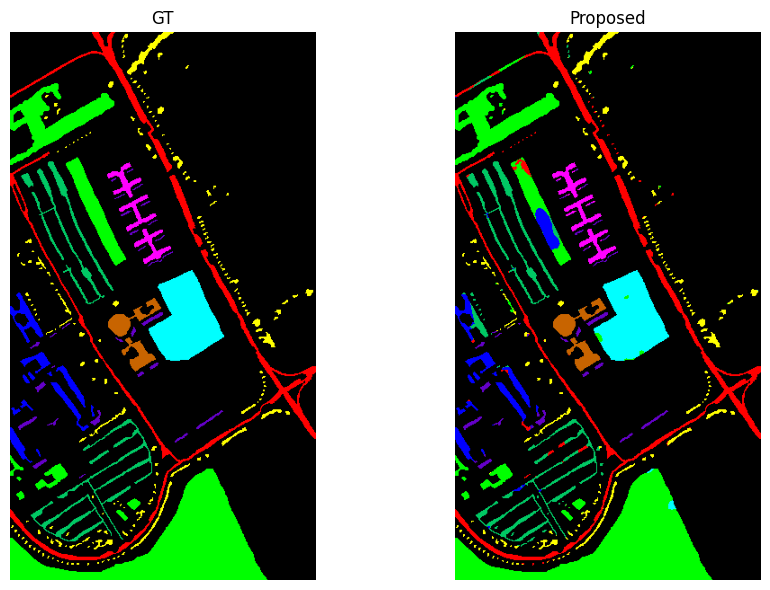

In [11]:
colors = np.array([
    [0,   0,   0],     # 0 background
    [255, 0,   0],     # 1 Asphalt
    [0,   255, 0],     # 2 Meadows
    [0,   0,   255],   # 3 Gravel
    [255, 255, 0],     # 4 Trees
    [255, 0,   255],   # 5 Painted metal sheets
    [0,   255, 255],   # 6 Bare soil
    [200, 100, 0],     # 7 Bitumen
    [0,   200, 100],   # 8 Self-blocking bricks
    [100, 0,   200],   # 9 Shadows
], dtype=np.uint8)


#Function to pass from the label to the associated color
def colorize_label_map(labels_map, palette = colors): 
    
    return palette[labels_map]


@torch.no_grad()
def predict_full_map(model, data_pad, H, W, patch_size, batch_size=256):
    
    model.eval()
    coords = [(y, x) for y in range(H) for x in range(W)]
    pred_flat = np.empty((H * W,), dtype=np.int32)

    
    for i in range(0, len(coords), batch_size):
        batch_coords = coords[i:i+batch_size]
        patches = []
        for (y, x) in batch_coords:
            p = extract_patch(data_pad, y, x)  # (C,P,P) 
            patches.append(p)
        patches = torch.from_numpy(np.stack(patches, axis=0)).float().to(device, non_blocking=True)  # (B,C,P,P)
        logits = model(patches)
        pred = torch.argmax(logits, dim=1).cpu().numpy().astype(np.int32)  
        pred_flat[i:i+len(batch_coords)] = pred + 1  

    return pred_flat.reshape(H, W)


best_model = CTA_full_model(
    in_bands=103,
    num_classes=num_classes,
    n_channels=128,
    patch_size=config_training["patch_size"],
    config=config_training,
    use_CT_block=True,
    use_channel_spatial_att=True
).to(device)

best_model.load_state_dict(torch.load("/kaggle/working/best_model_all_runs.pth", map_location=device))


pred_map = predict_full_map(
    best_model,
    data_pad=data_pad,
    H=H, W=W,
    patch_size=patch_size,
    batch_size=256
)  


pred_map_masked = pred_map.copy()
pred_map_masked[labels == 0] = 0

gt_map = labels.astype(np.int32)  

gt_rgb = colorize_label_map(gt_map, colors)
pred_rgb = colorize_label_map(pred_map_masked, colors)


plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(gt_rgb)
plt.title("GT")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_rgb)
plt.title("Proposed")
plt.axis("off")

plt.tight_layout()
plt.show()


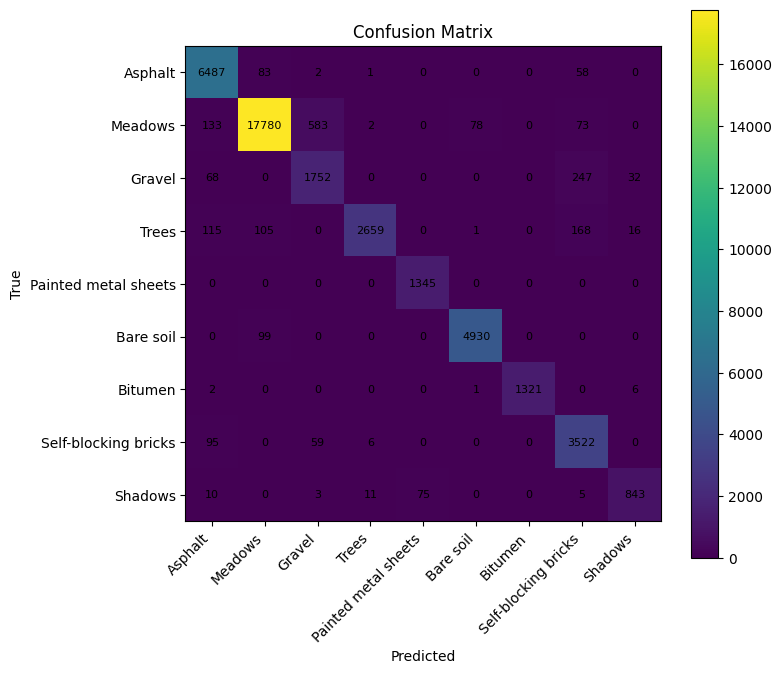

In [12]:
def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    
    plt.figure(figsize=(8, 7))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()

    n = cm.shape[0]
    plt.xticks(np.arange(n), class_names if class_names is not None else np.arange(1, n+1), rotation=45, ha="right")
    plt.yticks(np.arange(n), class_names if class_names is not None else np.arange(1, n+1))


    for i in range(n):
        for j in range(n):
            val = cm[i, j]
            txt = f"{int(val)}"
            plt.text(j, i, txt, ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()



mask = (labels != 0)
y_true = labels[mask].astype(np.int64) - 1          
y_pred = pred_map_masked[mask].astype(np.int64) - 1


cm = confusion_matrix(y_pred, y_true, num_classes)


class_names = [
    "Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets",
    "Bare soil", "Bitumen", "Self-blocking bricks", "Shadows"
]


plot_confusion_matrix(cm, class_names=class_names,  title="Confusion Matrix")

# Ablation Study

As mentioned above, the three key novelties added in this work are:
* ***Sample amplification***
* ***The hybrid module*** composed of CNN and Transformer, referred to as the CT block
* ***Channel-spatial attention***

The goal of the ablation study is to assess which of the three modules is more crucial for the achievement of good model performance. The study will consist of the reproduction of the experiments described (10 runs of training and testing with different initializations, taking the mean and std of the metrics) for three times, each *time removing one of the modules*.

From the results, it is clear that the ***key component is the CT block***, in fact we can see that all the three metrics exhibit a sharp drop in the experiment without that block. Overall Accuracy passes from 92.76 to 83.61, Average Accuracy from 92.36 to 85.21 and finally Kappa from 90.52 to 78.86, this last metric exhibits the largest drop.
The conclusion that can be drawn is that the hybrid module based on Convolution Neural Networks and Transformers is the core component, which is able to extract the most important local and non-local features of the patches, allowing to reach higher performance.

In the remaining two experiments, one without data augmentation and the other without channel-spatial attention, the performance shows a smaller decline, but since the drop is still present, the conclusion is that all three modules are essential to achieve the good performances reached.

In [13]:
#Ablation Study


flags = ["data_agumentation", "CT_block", "channel_spatial_attention"]

config_ablation = {
    "data_agumentation":True,
    "CT_block":True,
    "channel_spatial_attention":True
}
#Ablation study to see which component is more important
for flag_off in flags:
    cfg = config_ablation.copy()
    cfg[flag_off]=False
    
    BASE_SEED = 2040
    
    all_OA, all_AA, all_K, all_PC = [], [], [], []
      
    for i in range(10):
        seed = BASE_SEED + i
        test_metrics, _, _= train_one_run(seed,use_augmentation=cfg["data_agumentation"], ablation_study=True, use_CT_block = cfg["CT_block"], use_channel_spatial_att = cfg["channel_spatial_attention"])
        all_OA.append(test_metrics["OA"])
        all_AA.append(test_metrics["AA"])
        all_K.append(test_metrics["Kappa"])
        all_PC.append(test_metrics["per_class"])
    
            
    all_OA = np.array(all_OA)
    all_AA = np.array(all_AA)
    all_K  = np.array(all_K)
    all_PC = np.stack(all_PC, axis=0)  # (10, C)
    print(f"\nAblation study: results without using {flag_off} ")        
    print("\nFINAL STATISTICS (mean ± std over 10 runs)")
    print(f"OA    = {all_OA.mean()*100:.2f} ± {all_OA.std()*100:.2f}")
    print(f"AA    = {all_AA.mean()*100:.2f} ± {all_AA.std()*100:.2f}")
    print(f"Kappa = {all_K.mean()*100:.2f} ± {all_K.std()*100:.2f}")
            
    print("\nPer-class accuracy (mean ± std):")
    for c in range(num_classes):
         mu = all_PC[:, c].mean()*100
         sd = all_PC[:, c].std()*100
         print(f"Class {c+1:02d}: {mu:.2f} ± {sd:.2f}")



Ablation study: results without using data_agumentation 

FINAL STATISTICS (mean ± std over 10 runs)
OA    = 91.92 ± 3.22
AA    = 92.77 ± 1.67
Kappa = 89.53 ± 3.97

Per-class accuracy (mean ± std):
Class 01: 88.18 ± 6.21
Class 02: 91.23 ± 8.54
Class 03: 89.25 ± 8.16
Class 04: 90.48 ± 3.07
Class 05: 98.89 ± 1.95
Class 06: 96.94 ± 3.04
Class 07: 99.06 ± 1.61
Class 08: 94.34 ± 5.78
Class 09: 86.53 ± 7.43

Ablation study: results without using CT_block 

FINAL STATISTICS (mean ± std over 10 runs)
OA    = 83.61 ± 2.32
AA    = 85.21 ± 0.89
Kappa = 78.86 ± 2.80

Per-class accuracy (mean ± std):
Class 01: 67.24 ± 5.88
Class 02: 86.70 ± 5.42
Class 03: 79.10 ± 7.77
Class 04: 87.32 ± 3.32
Class 05: 99.05 ± 0.92
Class 06: 88.10 ± 4.58
Class 07: 94.57 ± 5.13
Class 08: 81.22 ± 9.59
Class 09: 83.56 ± 5.81

Ablation study: results without using channel_spatial_attention 

FINAL STATISTICS (mean ± std over 10 runs)
OA    = 92.42 ± 1.80
AA    = 92.08 ± 1.77
Kappa = 90.10 ± 2.31

Per-class accuracy (mea

# References and Reproducibility

**References**

This work is based on the following references:

* C. Fu, T. Zhou, T. Guo, Q. Zhu, F. Luo, and B. Du,
"CNN-Transformer and Channel-Spatial Attention based network for hyperspectral image classification with few samples,"
Neural Networks, vol. 186, art. no. 107283, 2025, doi: 10.1016/j.neunet.2025.107283

* Pavia University Hyperspectral Dataset. Available online through public hyperspectral data repositories (e.g., Kaggle, IEEE GRSS).



**Reproducibility Instructions**

The experiments are fully reproducible using Kaggle Notebooks.

Platform: Kaggle

Hardware: GPU-enabled environment (e.g.,P100)

To reproduce the results:

1. Upload the provided notebook file to Kaggle.

2. Add the Pavia University dataset as a Kaggle input dataset, specifically on kaggle the dataset is called "Pavia University HSI".

3. Enable GPU acceleration in the notebook settings.

4. Run all cells sequentially without modification.

No additional dependencies are required beyond the default Kaggle environment. All experiments are deterministic thanks to fixed random seeds, and results are reported as the mean and standard deviation over 10 independent runs, following the protocol of the reference paper.